In [1]:
import matplotlib.pyplot as plt #General Plotting
from matplotlib import cm
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(4)

Num samples: 0 = 2064, 1 = 2478, 2 = 2472, 3 = 2986


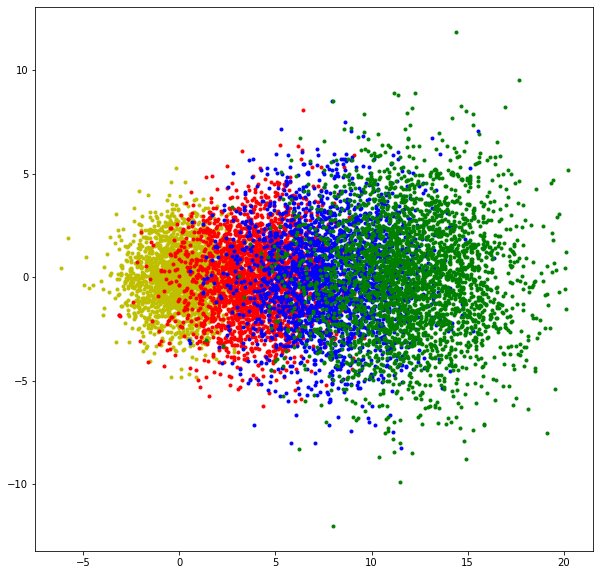

In [2]:
N = 10000 # samples
priors = np.array([.2,.25,.25,.3]) # Given Priors

# ARBITRARILY CHOSEN mean and covariance matrix
# equally spaced means along a line
mu =np.array([[0, 0],[4, 0],[8, 0],[12, 0]])
# scaled versions of the identity matrix with overlap
sigma =[[[2, 0],[0, 2]],
        [[4, 0],[0, 4]],
        [[6, 0],[0, 6]],
        [[8, 0],[0, 8]]]

n = mu.shape[1] # sample dimensions (2)
C = len(priors) # Classes (4)
L = np.array(range(C)) # labels [0 1 2 3]
Y = np.array(range(C))  # 0-(C-1)

# set thresholds: results in [0.0, 0.2, 0.45, 0.7, 1.0]
thresholds = np.cumsum(priors)
thresholds = np.insert(thresholds,0,0)

X = np.zeros([N,n]) # create empty matrix for samples of size 10,000 x 3
labels = np.zeros(N) # create empty labels array of length 10,000

# Create a 10000-length vector of uniformly distributed random variables in [0,1)
# Will be used to get an estimate of number of features belonging to each label
u = np.random.rand(N)

# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = '....'
marker_colors = 'rbgy' 

for i in range(C):

    # Find indices of u that meet each prior
    indices = np.argwhere((thresholds[i] <= u) & (u <= thresholds[i+1]))[:, 0]

    # Get the number of indices in each component - should be ~ 6500 and 3500
    Nl = len(indices)
    
    # set label vector based on above - will be vector of class labels [0 0 1 0 1 .. to 9999] in this case
    # for more classes, this can be [1 2 2 0 1 3 1 3 0 ...]
    labels[indices] = i * np.ones(Nl)
    
    # for each valid index, fill the 
    X[indices, :] = multivariate_normal.rvs(mu[i], sigma[i], Nl)
    plt.plot(X[labels==i, 0], X[labels==i, 1], marker_shapes[i-1] + marker_colors[i-1], label="True Class {}".format(i))

# Generate data distributions and store in true class labels
Nl = np.array([sum(labels == i) for i in range(C)])
print("Num samples: 0 = {}, 1 = {}, 2 = {}, 3 = {}".format(Nl[0],Nl[1],Nl[2],Nl[3]))

In [3]:
print(Y)


[0 1 2 3]


In [4]:
# Lambda Matrix
lambda_matrix = np.ones((C, C)) - np.identity(C)


# Calculate class-conditional likelihoods p(x|Y=j) for each label of the N observations
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[j], sigma[j]) for j in Y])
class_priors = np.diag(priors)
print(class_cond_likelihoods.shape)
print(class_priors.shape)
class_posteriors = class_priors.dot(class_cond_likelihoods)
print(class_posteriors)

# We want to create the risk matrix of size 3 x N 
cond_risk = lambda_matrix.dot(class_posteriors)
print(cond_risk)

# Get the decision for each column in risk_mat
decisions = np.argmin(cond_risk, axis=0)
print(decisions)

(4, 10000)
(4, 4)
[[1.25850841e-16 1.08202147e-15 1.17089332e-30 ... 1.46432440e-07
  2.45503386e-13 1.09495101e-20]
 [1.02314151e-05 2.12503478e-05 8.10303687e-11 ... 3.07733671e-03
  1.08391464e-04 4.61825895e-07]
 [2.40136963e-03 3.10627246e-03 1.80241487e-05 ... 4.60098737e-03
  4.47168360e-03 8.70969461e-04]
 [5.48807255e-03 5.60241755e-03 1.26811141e-03 ... 8.39243967e-04
  4.28457977e-03 5.64240722e-03]]
[[7.89967359e-03 8.72994036e-03 1.28613564e-03 ... 8.51756806e-03
  8.86465483e-03 6.51383851e-03]
 [7.88944217e-03 8.70869001e-03 1.28613556e-03 ... 5.44037777e-03
  8.75626337e-03 6.51337668e-03]
 [5.49830396e-03 5.62366790e-03 1.26811149e-03 ... 3.91672711e-03
  4.39297124e-03 5.64286904e-03]
 [2.41160104e-03 3.12752281e-03 1.80242297e-05 ... 7.67847052e-03
  4.58007506e-03 8.71431287e-04]]
[3 3 3 ... 2 2 3]


Confusion matrix:
[[0.89583333 0.11541566 0.00566343 0.        ]
 [0.10416667 0.74535916 0.20064725 0.01674481]
 [0.         0.13680387 0.55501618 0.18720697]
 [0.         0.00242131 0.23867314 0.79604823]]
Minimum Probability of Error:
0.25549999999999995


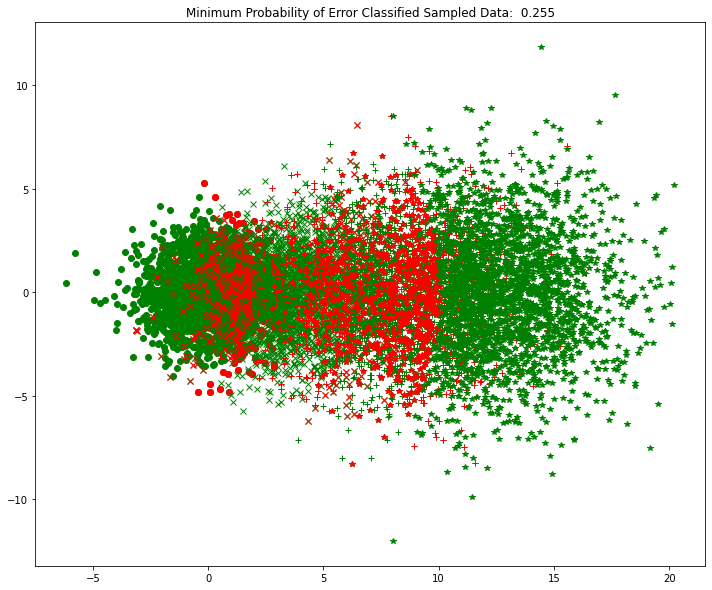

In [14]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(12, 10))
marker_shapes = 'ox+*.' # Accomodates up to C=5
marker_colors = 'brgmy'

# Get sample class counts
sample_class_counts = np.array([sum(labels == j) for j in Y])

# Confusion matrix
conf_mat = np.zeros((C, C))
for i in Y: # Each decision option
    for j in Y: # Each class label
        ind_ij = np.argwhere((decisions==i) & (labels==j))
        conf_mat[i, j] = len(ind_ij)/sample_class_counts[j] # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        marker = marker_shapes[j] + marker_colors[i]
        plt.plot(X[ind_ij, 0], X[ind_ij, 1], 'g'+marker_shapes[j], markersize=6)

        if i != j:
            plt.plot(X[ind_ij, 0], X[ind_ij, 1], 'r'+marker_shapes[j], markersize=6)
            
print("Confusion matrix:")
print(conf_mat)

print("Minimum Probability of Error:")
prob_error = 1 - np.diag(conf_mat).dot(sample_class_counts / N)
print(prob_error)

plt.title("Minimum Probability of Error Classified Sampled Data:  {:.3f}".format(prob_error))
plt.show()




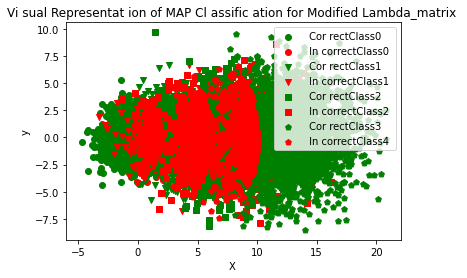

0.2578
[[0.8936170212765957, 0.10638297872340426, 0.0, 0.0], [0.11164852881902458, 0.7271261588069327, 0.1600161225312374, 0.0012091898428053204], [0.004704037632301058, 0.1736573892591141, 0.595452763622109, 0.2261858094864759], [0.0, 0.017702070808283232, 0.20240480961923848, 0.7798931195724783]]


In [ ]:
# Pa rtB
#cr e ate new lambda_matrix
lambda_matrix_b =[[ 0, 1, 2, 3],[1, 0, 1, 2],[2, 1, 0, 1],[3, 2, 1, 0]]
loss_matrix =[[ 0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 0, 0]]
# plotnew d ata us ing get_MAP f u n ctionabov e
plt.figure(2)
correct,incorrect= get_MAP(0, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'o',label= ' Cor rectClass0 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'o',label= ' In correctClass0 ')
correct,incorrect= get_MAP(1, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'v',label= ' Cor rectClass1 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'v',label= ' In correctClass1 ')
correct,incorrect= get_MAP(2, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 's',label= ' Cor rectClass2 ')
plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 's',label= ' In correctClass2 ')
correct,incorrect= get_MAP(3, lambda_matrix_b)
plt.scatter(correct[ 0], correct[ 1], c= 'g', marker= 'p',label= ' Cor rectClass3 ')

plt.scatter(incorrect[ 0],incorrect[ 1], c= 'r', marker= 'p',label= ' In correctClass4 ')
plt.legend()
plt.title('Vi sual Representat ion of MAP Cl assific ation for Modified Lambda_matrix ')
plt.xlabel('X ')
plt.ylabel('y')
plt.show()
# calculatetotallos s
total_loss= 0
for i in range(0, 4):
        for j in range(0, 4):
            if i != j :
                total_loss=total_loss+ loss_matrix [i][j]
print(total_loss/N)
# calculate con f u sio n matrix from lossmatr ix
for i in range(0, 4):
    loss_matrix [i] =[x / N_samples [i] for x in loss_matrix [i]]
print(loss_matrix)



